In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pwlf
from sklearn.linear_model import HuberRegressor, LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

In [43]:
df_japan = pd.read_csv('data/japan.list', sep=' ', names=['distance', 'depth'])
df_japan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420 entries, 0 to 419
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   distance  420 non-null    float64
 1   depth     420 non-null    float64
dtypes: float64(2)
memory usage: 6.7 KB


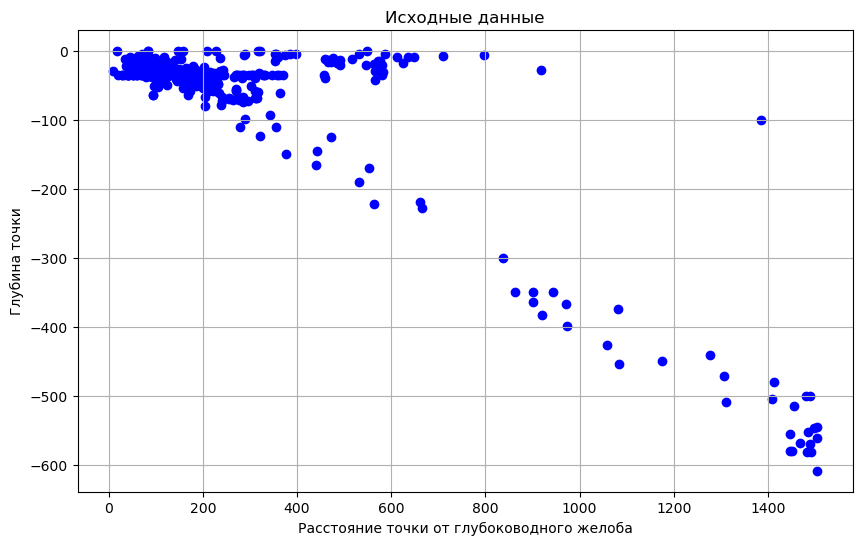

In [44]:
plt.figure(figsize=(10, 6))
plt.scatter(df_japan.distance, df_japan.depth, color='blue')
plt.xlabel('Расстояние точки от глубоководного желоба')
plt.ylabel('Глубина точки')
plt.title('Исходные данные')
plt.grid();

In [45]:
# Стандартизация исходных данных

std_scaler = StandardScaler()
std_scaler.fit(df_japan)
std_scaled = std_scaler.transform(df_japan)
df_japan[['std_scaled_distance', 'std_scaled_depth']] = std_scaled

# Средние и масштабы для обратного преобразования
mu_X = std_scaler.mean_[0]
sigma_X = std_scaler.scale_[0]
mu_y = std_scaler.mean_[1]
sigma_y = std_scaler.scale_[1]

df_japan

,distance,depth,std_scaled_distance,std_scaled_depth
0,8.744228,-30.1,-0.868451,0.337792
1,18.090458,0.0,-0.839859,0.583253
2,20.066726,-35.0,-0.833814,0.297834
3,28.427862,-35.0,-0.808236,0.297834
4,28.427862,-35.0,-0.808236,0.297834
...,...,...,...,...
415,1491.997576,-581.3,3.668968,-4.157147
416,1497.876215,-547.2,3.686952,-3.879068
417,1503.633237,-562.0,3.704563,-3.999759
418,1504.039132,-608.8,3.705805,-4.381405


In [46]:
X = df_japan[['std_scaled_distance']]
y = df_japan['std_scaled_depth']

degree = 1 # Степень полинома для полиномиальных признаков
poly_feature = PolynomialFeatures(degree=degree, include_bias=False)
X_poly = poly_feature.fit_transform(X)

# Создание модели робастной регрессии
huber = HuberRegressor()

# Определение распределения гиперпараметров для поиска
param_distributions_huber = {
    'epsilon': uniform(1.0, 2.0),
    'max_iter': [100, 200, 300, 400, 500],
    'alpha': uniform(0.0001, 0.01)
}
# Поиск лучших гиперпараметров
random_search_huber = RandomizedSearchCV(huber, param_distributions_huber, n_iter=100, cv=5, random_state=42)
random_search_huber.fit(X_poly, y)
print("Лучшие параметры:", random_search_huber.best_params_)

Лучшие параметры: {'alpha': 0.002087156815341724, 'epsilon': 1.0110442342472048, 'max_iter': 300}


Коэффициенты: [-0.34993575]
Свободный член: 188.66715726944403


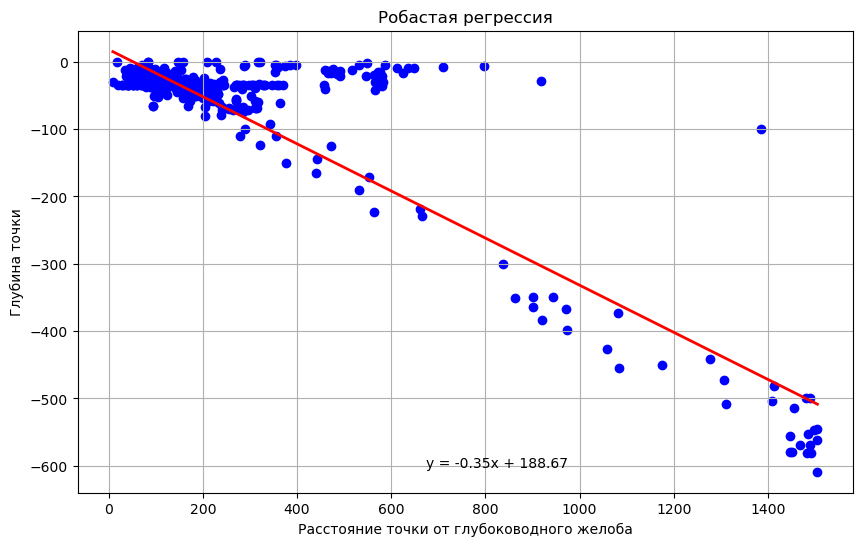

In [47]:
# Создание окончательной модели с лучшими гиперпараметрами
huber = HuberRegressor(**random_search_huber.best_params_)
huber.fit(X_poly, y)

# Предсказывание значений с помощью обученной модели
pred_huber = huber.predict(X_poly)

# Получение коэффициентов модели и независимого члена
coefficients_huber = huber.coef_
intercept_huber = huber.intercept_

# Преобразование предсказанных значений обратно в исходный масштаб
pred_huber_original = pred_huber * sigma_y + mu_y

# Преобразование коэффициентов и свободного члена в исходный масштаб
coefficients_huber_original = coefficients_huber * (sigma_y / sigma_X)
intercept_huber_original = intercept_huber * sigma_y + mu_y - (coefficients_huber * mu_X).sum()

print("Коэффициенты:", coefficients_huber_original)
print("Свободный член:", intercept_huber_original)

# Визуализиция данных и модели

formula_text_huber = f'y = {coefficients_huber_original[0]:.2f}x + {intercept_huber_original:.2f}'

plt.figure(figsize=(10, 6))
plt.scatter(X * sigma_X + mu_X, y * sigma_y + mu_y, color='blue')
plt.plot(X * sigma_X + mu_X, pred_huber_original, color='red', linewidth=2)
plt.text(0.45, 0.08, formula_text_huber, transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
plt.xlabel('Расстояние точки от глубоководного желоба')
plt.ylabel('Глубина точки')
plt.title('Робастая регрессия')
plt.grid()
plt.show();

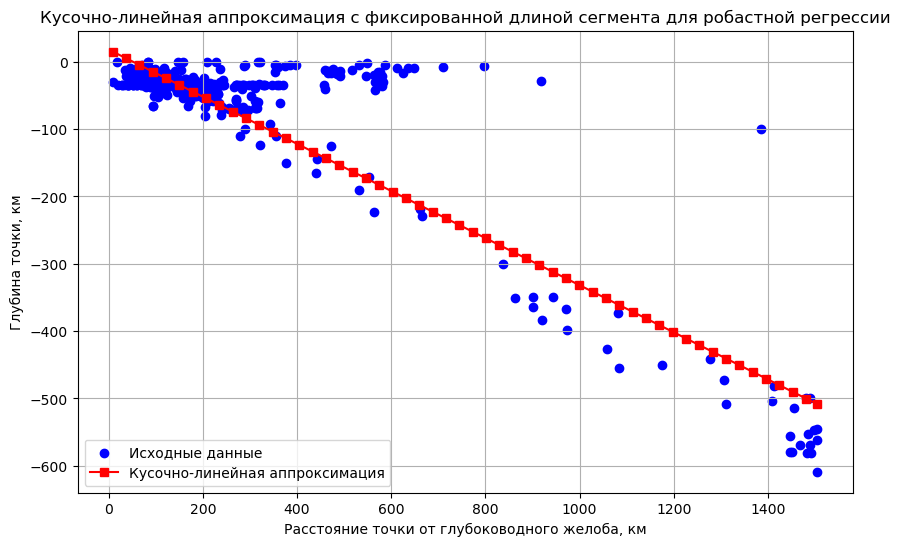

Угол наклона сегмента 0: -19.29 градусов.
Угол наклона сегмента 1: -19.29 градусов.
Угол наклона сегмента 2: -19.29 градусов.
Угол наклона сегмента 3: -19.29 градусов.
Угол наклона сегмента 4: -19.29 градусов.
Угол наклона сегмента 5: -19.29 градусов.
Угол наклона сегмента 6: -19.29 градусов.
Угол наклона сегмента 7: -19.29 градусов.
Угол наклона сегмента 8: -19.29 градусов.
Угол наклона сегмента 9: -19.29 градусов.
Угол наклона сегмента 10: -19.29 градусов.
Угол наклона сегмента 11: -19.29 градусов.
Угол наклона сегмента 12: -19.29 градусов.
Угол наклона сегмента 13: -19.29 градусов.
Угол наклона сегмента 14: -19.29 градусов.
Угол наклона сегмента 15: -19.29 градусов.
Угол наклона сегмента 16: -19.29 градусов.
Угол наклона сегмента 17: -19.29 градусов.
Угол наклона сегмента 18: -19.29 градусов.
Угол наклона сегмента 19: -19.29 градусов.
Угол наклона сегмента 20: -19.29 градусов.
Угол наклона сегмента 21: -19.29 градусов.
Угол наклона сегмента 22: -19.29 градусов.
Угол наклона сегмента

In [48]:
# Длина сегмента для кусочно-линейной аппроксимации
segment_length = 30

# Применение скаляризации к данным
X_appr = X.values.flatten() * sigma_X + mu_X
y_appr_huber = pred_huber_original 

# Функция для вычисления евклидова расстояния между двумя точками
def euclidean_distance(p1, p2):
    return np.linalg.norm(p1 - p2)

# Функция для кусочно-линейной аппроксимации
def approximation(X_appr, y_appr, segment_length):
    nodes = [(X_appr[0], y_appr[0])]
    total_distance = 0.0
    current_node = np.array(nodes[0])
    
    for i in range(1, len(X_appr)):
        next_point = np.array([X_appr[i], y_appr[i]])
        dist = euclidean_distance(current_node, next_point)
        
        while total_distance + dist >= segment_length:
            ratio = (segment_length - total_distance) / dist
            new_node = current_node + ratio * (next_point - current_node)
            nodes.append(tuple(new_node))
            current_node = new_node
            total_distance = 0.0
            dist = euclidean_distance(current_node, next_point)
        
        total_distance += dist
        current_node = next_point
   
    nodes.append((X_appr[-1], y_appr[-1]))  # Добавляем последний узел

    angles = [np.arctan2(nodes[i + 1][1] - nodes[i][1], nodes[i + 1][0] - nodes[i][0])
              for i in range(len(nodes) - 1)]
    
    return zip(*nodes), angles

# Применение аппроксимации для робастой регрессии
(hx_huber, hy_huber), angles_huber = approximation(X_appr, y_appr_huber, segment_length)

# Визуализация результатов аппроксимации
plt.figure(figsize=(10, 6))
plt.scatter(X * sigma_X + mu_X, y * sigma_y + mu_y, color='blue', label='Исходные данные')
plt.plot(hx_huber, hy_huber, 'rs-', label='Кусочно-линейная аппроксимация')
plt.title('Кусочно-линейная аппроксимация с фиксированной длиной сегмента для робастной регрессии')
plt.xlabel('Расстояние точки от глубоководного желоба, км')
plt.ylabel('Глубина точки, км')
plt.legend()
plt.grid()
plt.show()

# Вывод углов наклона сегментов
for i, angle in enumerate(angles_huber):
    print(f"Угол наклона сегмента {i}: {np.degrees(angle):.2f} градусов.")

In [49]:
# Создание модели неробастной (линейной) регрессии
lin_reg = LinearRegression()

# Определение распределения гиперпараметров для поиска
param_distributions = {
    'fit_intercept': [True, False],
    'copy_X': [True, False],
    'n_jobs': [None, -1, 1],
    'positive': [True, False]
}

# Поиск лучших гиперпараметров
random_search_lin_reg = RandomizedSearchCV(lin_reg, param_distributions, n_iter=10, cv=5, random_state=42)
random_search_lin_reg.fit(X_poly, y)
print("Лучшие параметры:", random_search_lin_reg.best_params_)

Лучшие параметры: {'positive': False, 'n_jobs': 1, 'fit_intercept': False, 'copy_X': True}


Коэффициенты: [-0.3320329]
Свободный член: 25.642128861031907


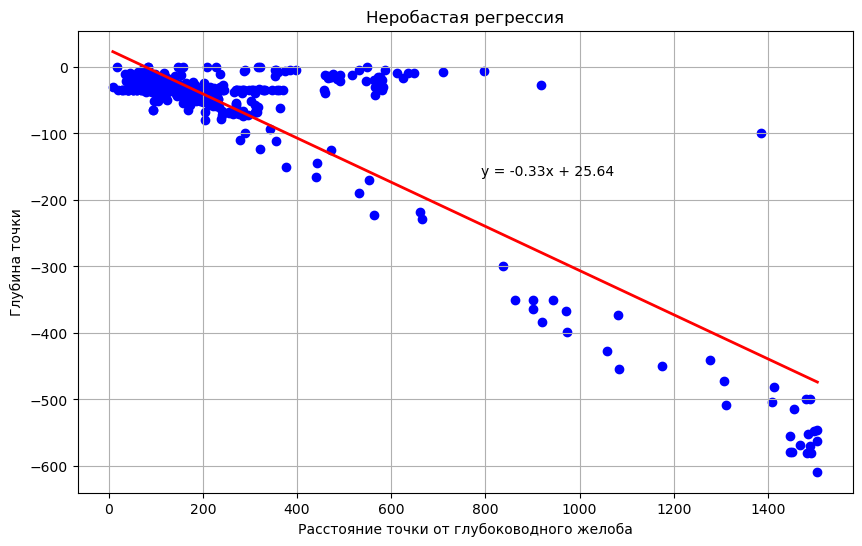

In [50]:
# Создание окончательной модели с лучшими гиперпараметрами
lin_reg = LinearRegression(**random_search_lin_reg.best_params_)
lin_reg.fit(X_poly, y)

# Предсказывание значений с помощью обученной модели
pred_lin_reg = lin_reg.predict(X_poly)

# Преобразование предсказанных значений обратно в исходный масштаб
pred_lin_reg_original = pred_lin_reg * sigma_y + mu_y

# Преобразование коэффициентов и свободного члена в исходный масштаб
coefficients_lin_reg = lin_reg.coef_ * (sigma_y / sigma_X)
intercept_lin_reg_original = lin_reg.intercept_ * sigma_y + mu_y - (coefficients_lin_reg * mu_X).sum()

print("Коэффициенты:", coefficients_lin_reg)
print("Свободный член:", intercept_lin_reg_original)

# Визуализация результатов линейной регрессии

formula_text_lin_reg = f'y = {coefficients_lin_reg[0]:.2f}x + {intercept_lin_reg_original:.2f}'

plt.figure(figsize=(10, 6))
plt.scatter(X * sigma_X + mu_X, y * sigma_y + mu_y, color='blue')
plt.plot(X * sigma_X + mu_X, pred_lin_reg_original, color='red', linewidth=2)
plt.text(0.52, 0.71, formula_text_lin_reg, transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
plt.xlabel('Расстояние точки от глубоководного желоба')
plt.ylabel('Глубина точки')
plt.title('Неробастая регрессия')
plt.grid()
plt.show()

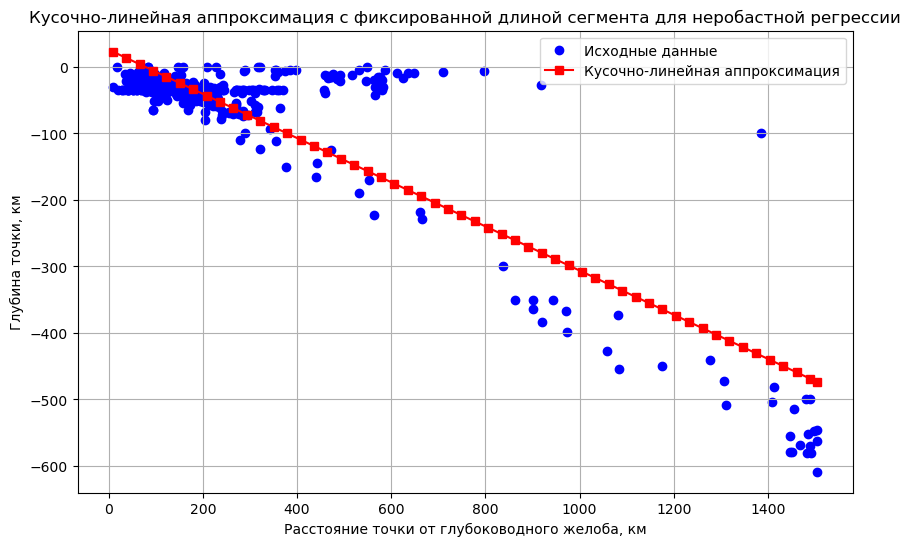

Угол наклона сегмента 0: -18.37 градусов.
Угол наклона сегмента 1: -18.37 градусов.
Угол наклона сегмента 2: -18.37 градусов.
Угол наклона сегмента 3: -18.37 градусов.
Угол наклона сегмента 4: -18.37 градусов.
Угол наклона сегмента 5: -18.37 градусов.
Угол наклона сегмента 6: -18.37 градусов.
Угол наклона сегмента 7: -18.37 градусов.
Угол наклона сегмента 8: -18.37 градусов.
Угол наклона сегмента 9: -18.37 градусов.
Угол наклона сегмента 10: -18.37 градусов.
Угол наклона сегмента 11: -18.37 градусов.
Угол наклона сегмента 12: -18.37 градусов.
Угол наклона сегмента 13: -18.37 градусов.
Угол наклона сегмента 14: -18.37 градусов.
Угол наклона сегмента 15: -18.37 градусов.
Угол наклона сегмента 16: -18.37 градусов.
Угол наклона сегмента 17: -18.37 градусов.
Угол наклона сегмента 18: -18.37 градусов.
Угол наклона сегмента 19: -18.37 градусов.
Угол наклона сегмента 20: -18.37 градусов.
Угол наклона сегмента 21: -18.37 градусов.
Угол наклона сегмента 22: -18.37 градусов.
Угол наклона сегмента

In [51]:
# Применение аппроксимации для неробастой (линейной) регрессии
(hx_lin_reg, hy_lin_reg), angles_lin_reg = approximation(X_appr, pred_lin_reg_original, segment_length)

# Визуализация результатов аппроксимации
plt.figure(figsize=(10, 6))
plt.scatter(X * sigma_X + mu_X, y * sigma_y + mu_y, color='blue', label='Исходные данные')
plt.plot(hx_lin_reg, hy_lin_reg, 'rs-', label='Кусочно-линейная аппроксимация')
plt.xlabel('Расстояние точки от глубоководного желоба, км')
plt.ylabel('Глубина точки, км')
plt.title('Кусочно-линейная аппроксимация с фиксированной длиной сегмента для неробастной регрессии')
plt.legend()
plt.grid()
plt.show()

# Вывод углов наклона сегментов
for i, angle in enumerate(angles_lin_reg):
    print(f"Угол наклона сегмента {i}: {np.degrees(angle):.2f} градусов.")

In [52]:
# Фильтрация данных (исключение данных с глубинами 33 и 35 км)
df_japan_cleaned = df_japan[(df_japan.depth != -33) & (df_japan.depth != -35)]

X_cleaned = df_japan_cleaned[['std_scaled_distance']]
y_cleaned = df_japan_cleaned['std_scaled_depth']

poly_features_cleaned = PolynomialFeatures(degree=degree, include_bias=False)
X_cleaned_poly = poly_features_cleaned.fit_transform(X_cleaned)

# Создание модели робастной регрессии
huber_cleaned = HuberRegressor()

# Поиск лучших гиперпараметров
random_search_huber_cleaned = RandomizedSearchCV(huber_cleaned, param_distributions_huber, n_iter=100, cv=5, random_state=42)
random_search_huber_cleaned.fit(X_cleaned_poly, y_cleaned)
print("Лучшие параметры:", random_search_huber_cleaned.best_params_)

Лучшие параметры: {'alpha': 0.002087156815341724, 'epsilon': 1.0110442342472048, 'max_iter': 300}


Коэффициенты: [-0.36251036]
Свободный член: 197.2552067119488


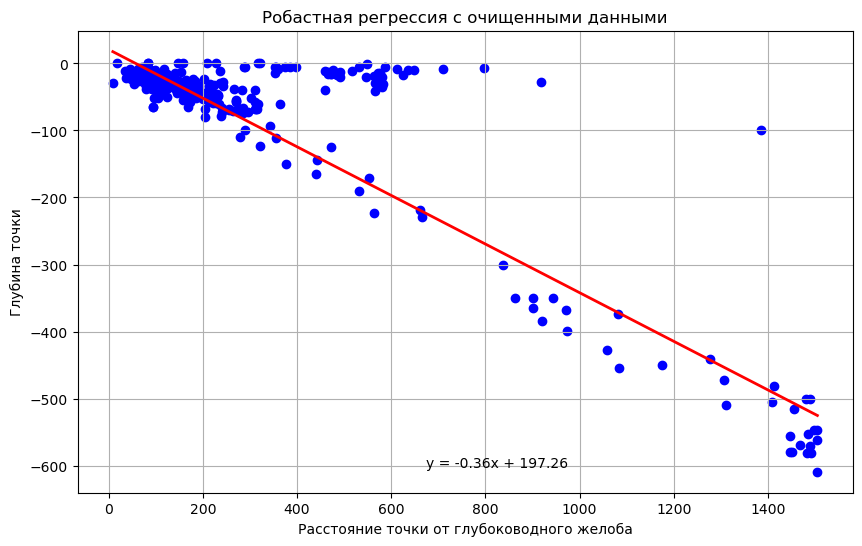

In [53]:
# Создание окончательной модели с лучшими гиперпараметрами
huber_cleaned = HuberRegressor(**random_search_huber_cleaned.best_params_)
huber_cleaned.fit(X_cleaned_poly, y_cleaned)

# Предсказывание значений с помощью обученной модели
pred_huber_cleaned = huber_cleaned.predict(X_cleaned_poly)

# Получение коэффициентов модели и независимого члена
coefficients_huber_cleaned = huber_cleaned.coef_
intercept_huber_cleaned = huber_cleaned.intercept_

# Преобразование значений X обратно в исходный масштаб
X_cleaned_original = X_cleaned.values.flatten() * sigma_X + mu_X

# Преобразование предсказанных значений обратно в исходный масштаб
pred_huber_cleaned_original = pred_huber_cleaned * sigma_y + mu_y

# Преобразование коэффициентов и свободного члена в исходный масштаб
coefficients_huber_cleaned_original = coefficients_huber_cleaned * (sigma_y / sigma_X)
intercept_huber_cleaned_original = intercept_huber_cleaned * sigma_y + mu_y - (coefficients_huber_cleaned * mu_X).sum()

print("Коэффициенты:", coefficients_huber_cleaned_original)
print("Свободный член:", intercept_huber_cleaned_original)

# Визуализация данных и модели

formula_text_huber_cleaned = f'y = {coefficients_huber_cleaned_original[0]:.2f}x + {intercept_huber_cleaned_original:.2f}'

plt.figure(figsize=(10, 6))
plt.scatter(X_cleaned * sigma_X + mu_X, y_cleaned * sigma_y + mu_y, color='blue')
plt.plot(X_cleaned * sigma_X + mu_X, pred_huber_cleaned_original, color='red', linewidth=2)
plt.text(0.45, 0.08, formula_text_huber_cleaned, transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
plt.xlabel('Расстояние точки от глубоководного желоба')
plt.ylabel('Глубина точки')
plt.title('Робастная регрессия с очищенными данными')
plt.grid()
plt.show();

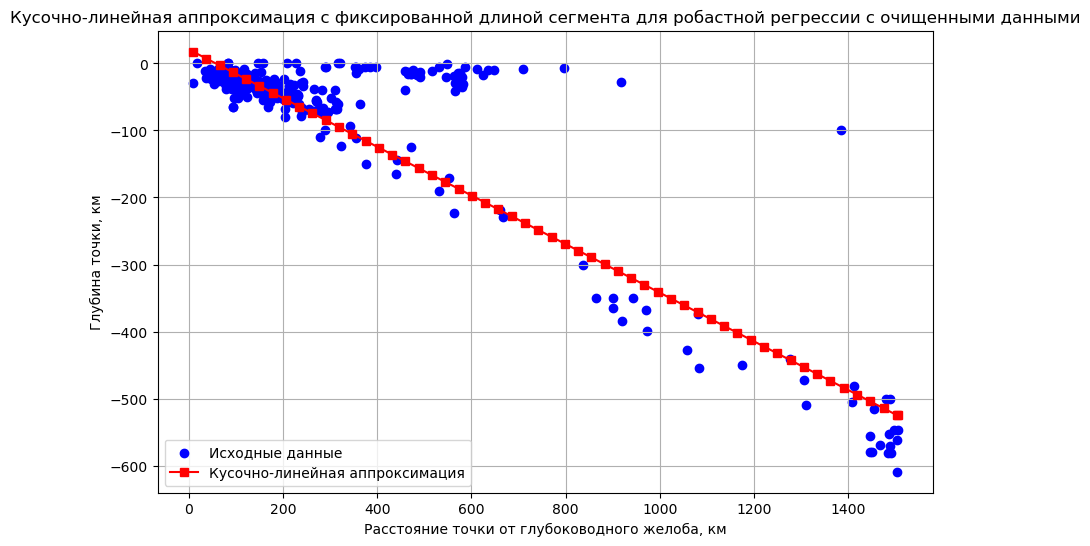

Угол наклона сегмента 0: -19.926105399856507 градусов.
Угол наклона сегмента 1: -19.926105399856517 градусов.
Угол наклона сегмента 2: -19.92610539985652 градусов.
Угол наклона сегмента 3: -19.926105399856528 градусов.
Угол наклона сегмента 4: -19.926105399856525 градусов.
Угол наклона сегмента 5: -19.926105399856517 градусов.
Угол наклона сегмента 6: -19.926105399856528 градусов.
Угол наклона сегмента 7: -19.926105399856517 градусов.
Угол наклона сегмента 8: -19.926105399856496 градусов.
Угол наклона сегмента 9: -19.926105399856542 градусов.
Угол наклона сегмента 10: -19.926105399856517 градусов.
Угол наклона сегмента 11: -19.926105399856542 градусов.
Угол наклона сегмента 12: -19.926105399856493 градусов.
Угол наклона сегмента 13: -19.926105399856542 градусов.
Угол наклона сегмента 14: -19.926105399856517 градусов.
Угол наклона сегмента 15: -19.926105399856493 градусов.
Угол наклона сегмента 16: -19.926105399856542 градусов.
Угол наклона сегмента 17: -19.926105399856542 градусов.
Уго

In [54]:
# Применение аппроксимации для робастной регрессии
(hx_huber_cleaned, hy_huber_cleaned), angles_huber_cleaned = approximation(X_cleaned_original, pred_huber_cleaned_original, segment_length)

# Визуализация результатов аппроксимации
plt.figure(figsize=(10, 6))
plt.scatter(X_cleaned * sigma_X + mu_X, y_cleaned * sigma_y + mu_y, color='blue', label='Исходные данные')
plt.plot(hx_huber_cleaned, hy_huber_cleaned, 'rs-', label='Кусочно-линейная аппроксимация')
plt.title('Кусочно-линейная аппроксимация с фиксированной длиной сегмента для робастной регрессии с очищенными данными')
plt.xlabel('Расстояние точки от глубоководного желоба, км')
plt.ylabel('Глубина точки, км')
plt.legend()
plt.grid()
plt.show()

# Вывод углов наклона сегментов
for i, angle in enumerate(angles_huber_cleaned):
    print(f"Угол наклона сегмента {i}: {np.degrees(angle)} градусов.")